# Real-world Data Wrangling

In this project, you will apply the skills you acquired in the course to gather and wrangle real-world data with two datasets of your choice.

You will retrieve and extract the data, assess the data programmatically and visually, accross elements of data quality and structure, and implement a cleaning strategy for the data. You will then store the updated data into your selected database/data store, combine the data, and answer a research question with the datasets.

Throughout the process, you are expected to:

1. Explain your decisions towards methods used for gathering, assessing, cleaning, storing, and answering the research question
2. Write code comments so your code is more readable

## 1. Gather data

In this section, you will extract data using two different data gathering methods and combine the data. Use at least two different types of data-gathering methods.

### **1.1. Problem Statement**

Air pollution is one of the most critical environmental issues worldwide, impacting human health and quality of life. 
In this project, I aim to explore the relationship between weather conditions (temperature, humidity, wind speed) and air pollution levels (PM2.5, NO₂, O₃) in Rome, Italy. 
The goal is to assess whether certain meteorological factors correlate with variations in pollutant concentrations.

To conduct this analysis, I will gather daily weather data from the OpenWeather API and air quality data from the European Environment Agency (EEA) open data portal. 
These datasets will be merged on date and city for combined analysis.


### **1.2.** Gather at least two datasets using two different data gathering methods

List of data gathering methods:

- Download data manually
- Programmatically downloading files
- Gather data by accessing APIs
- Gather and extract data from HTML files using BeautifulSoup
- Extract data from a SQL database

Each dataset must have at least two variables, and have greater than 500 data samples within each dataset.

For each dataset, briefly describe why you picked the dataset and the gathering method (2-3 full sentences), including the names and significance of the variables in the dataset. Show your work (e.g., if using an API to download the data, please include a snippet of your code). 

Load the dataset programmtically into this notebook.

#### **Dataset 1**

- **Type**: JSON (API response)  
- **Source**: [Open-Meteo Archive API (ERA5)](https://open-meteo.com)  
- **Method**: Programmatically gathered via HTTP request using the `requests` library.  
- **Variables**:  
  * `date` — date of observation (UTC)  
  * `temp_c` — daily average temperature in Celsius  
  * `rhum_pct` — daily average relative humidity (%)  
  * `wind_speed_ms` — daily average wind speed (m/s)  
  * `precip_mm` — daily total precipitation (mm)  


In [32]:
from modules.openmeteo_weather import build_weather_daily

weather_df_daily = build_weather_daily(
    lat=41.9028,
    lon=12.4964,
    start="2022-01-01",
    end="2024-12-31",
    timezone="Europe/Rome"
)

print(weather_df_daily.head(3))
print(weather_df_daily.tail(3))


         date    temp_c   rhum_pct  wind_speed_ms  precip_mm
0  2022-01-01  7.958333  90.708333       4.916667        0.0
1  2022-01-02  7.725000  92.000000       5.516667        0.0
2  2022-01-03  8.741667  89.208333       5.200000        0.5
            date    temp_c   rhum_pct  wind_speed_ms  precip_mm
1093  2024-12-29  5.608333  82.875000       4.070833        0.0
1094  2024-12-30  5.933333  82.583333       3.741667        0.0
1095  2024-12-31  5.483333  88.583333       4.691667        0.0


#### **Dataset 2**

- **Type**: CSV file
- **Source**: [OpenAQ API v3](https://api.openaq.org/)  
- **Variables**:  
  * `date` — date of observation (UTC)  
  * `pm25` — daily average PM₂.₅ concentration (µg/m³)  
  * `no2` — daily average NO₂ concentration (µg/m³)  


In [33]:
from modules.openaq_loader import OpenAQClient, load_and_aggregate_from_openaq
import pandas as pd

# Import the air quality data into a DataFrame
aq_daily_2022= pd.read_csv("data/raw/air_quality_rome_2022.csv")
aq_daily_2023 = pd.read_csv("data/raw/air_quality_rome_2023.csv")
aq_daily_2024 = pd.read_csv("data/raw/air_quality_rome_2024.csv")

aq_daily= pd.concat([aq_daily_2022, aq_daily_2023, aq_daily_2024], ignore_index=True)

print(aq_daily.head(3))
print(aq_daily.tail(3))

         date  city  pm25_rome  no2_rome
0  2022-01-01  Rome        NaN     43.50
1  2022-01-02  Rome        NaN     51.85
2  2022-01-03  Rome        NaN     32.15
            date  city  pm25_rome  no2_rome
1039  2024-12-28  Rome       19.0      53.7
1040  2024-12-29  Rome       48.0      59.2
1041  2024-12-30  Rome       50.0      57.1


Optional data storing step: You may save your raw dataset files to the local data store before moving to the next step.

#### **Relationship between Dataset 1 and Dataset 2**

Both datasets refer to environmental conditions in Rome during 2024.  
Dataset 1 contains daily weather variables (temperature, humidity, wind speed, and precipitation) from the Open-Meteo ERA5 reanalysis, while Dataset 2 contains daily air quality measurements (PM₂.₅ and NO₂) from OpenAQ.  
They share a common `date` field, which allows the datasets to be merged for exploratory analysis of the relationship between meteorological conditions and air pollution levels.

## 2. Assess data

Assess the data according to data quality and tidiness metrics using the report below.

List **two** data quality issues and **two** tidiness issues. Assess each data issue visually **and** programmatically, then briefly describe the issue you find.  **Make sure you include justifications for the methods you use for the assessment.**

In [34]:
# Declaring function used to assess the datasets
def assess_dataset(df, name):
    print(f"\n--- {name} ---")
    print(df.info())
    print("Shape:", df.shape)
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values per column:")
    print(df.isna().sum())
    print("\nDuplicate rows:", df.duplicated().sum())
    print("\nSummary statistics:")
    print(df.describe(include="all"))

# function to assess duplicated dates
def assess_duplicates(df):
    duplicates_mask = df['date'].duplicated(keep=False)  # keep=False marks all duplicates
    num_duplicates = df["date"].duplicated().sum()
    
    if num_duplicates > 0:
        print(f"There are {num_duplicates} duplicated dates.")
    else:
        print("No duplicated dates found.")

### Dataset 1 – Data Quality Issue

1. Data types are correct except for the `date` column, which is stored as `object` instead of `datetime.date`.
2. Outliers in `precip_mm` (unusually high daily precipitation values that may be due to measurement or aggregation errors).

In [35]:
# Assess Dataset 1 (Weather)
assess_dataset(weather_df_daily, "Weather Data (Dataset 1)")
assess_duplicates(weather_df_daily)


--- Weather Data (Dataset 1) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1096 non-null   object 
 1   temp_c         1096 non-null   float64
 2   rhum_pct       1096 non-null   float64
 3   wind_speed_ms  1096 non-null   float64
 4   precip_mm      1096 non-null   float64
dtypes: float64(4), object(1)
memory usage: 42.9+ KB
None
Shape: (1096, 5)

Data types:
date              object
temp_c           float64
rhum_pct         float64
wind_speed_ms    float64
precip_mm        float64
dtype: object

Missing values per column:
date             0
temp_c           0
rhum_pct         0
wind_speed_ms    0
precip_mm        0
dtype: int64

Duplicate rows: 0

Summary statistics:
              date       temp_c     rhum_pct  wind_speed_ms    precip_mm
count         1096  1096.000000  1096.000000    1096.000000  1096.000000
uni

/var/folders/sn/xrsxvpkj4bx6b_6m3_7zbjz80000gn/T/ipykernel_40837/1396895413.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([weather_df_daily[c] for c in cols], labels=cols)


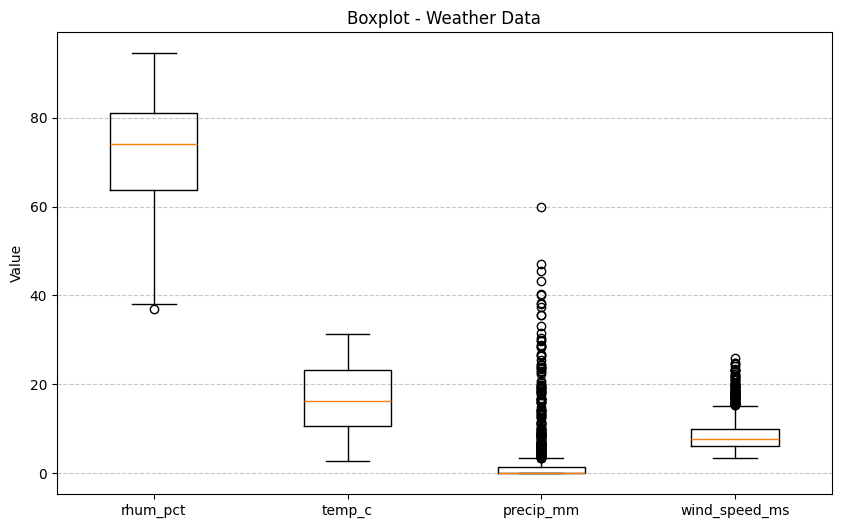

In [36]:
import matplotlib.pyplot as plt

cols = ["rhum_pct", "temp_c", "precip_mm", "wind_speed_ms"]

plt.figure(figsize=(10, 6))
plt.boxplot([weather_df_daily[c] for c in cols], labels=cols)
plt.title("Boxplot - Weather Data")
plt.ylabel("Value")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Justification: **
#### Outliers in Precipitation Data
The boxplot for `precip_mm` shows several high-value outliers.  
These are likely caused by **extreme weather events** such as thunderstorms or heavy rain episodes, which naturally produce daily precipitation amounts significantly above the median.  

Unlike measurement errors, these extreme values are **expected in meteorological data** and are important to retain for analysis, since they provide insight into unusual but real climatic conditions.  
For this reason, no outlier removal will be applied to precipitation data.

#### Outliers in Wind Speed Data

The boxplot for `wind_speed_ms` shows some high-value outliers.  
These are likely the result of **strong wind events** such as storms or intense gusts, which can cause daily average wind speeds to spike above typical levels.  

In meteorological datasets, such peaks are **real and meaningful phenomena**, not measurement errors, and can be crucial for understanding weather extremes.  
Therefore, outliers in wind speed will be retained in the dataset.

### Dataset 2 – Data Quality Issue

1. Missing values in `pm25` and `no2` for certain dates.
2. The `date` column is stored as `object` instead of `datetime.date`.
3. Potential anomalies in pollutant concentrations (very high spikes likely due to sensor errors).

In [37]:
# Assess Dataset 2 (Air Quality)
assess_dataset(aq_daily, "Air Quality Data (Dataset 2)")
assess_duplicates(aq_daily)


--- Air Quality Data (Dataset 2) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       1042 non-null   object 
 1   city       1042 non-null   object 
 2   pm25_rome  754 non-null    float64
 3   no2_rome   1038 non-null   float64
dtypes: float64(2), object(2)
memory usage: 32.7+ KB
None
Shape: (1042, 4)

Data types:
date          object
city          object
pm25_rome    float64
no2_rome     float64
dtype: object

Missing values per column:
date           0
city           0
pm25_rome    288
no2_rome       4
dtype: int64

Duplicate rows: 0

Summary statistics:
              date  city   pm25_rome     no2_rome
count         1042  1042  754.000000  1038.000000
unique        1042     1         NaN          NaN
top     2022-01-01  Rome         NaN          NaN
freq             1  1042         NaN          NaN
mean           NaN   NaN   13.1

**Justification:**

There are not missing values for no2 while only few for pm25. Therefore the NaNs columns can be used to drop data of that day of the year without significant impact for the overall analysis.

### Dataset 1 – Data Tidiness Issue

1. No structural tidiness problems detected – each variable is in its own column, each row is a unique date.

In [38]:
weather_df_daily.head(10)
weather_df_daily.tail(10)

,date,temp_c,rhum_pct,wind_speed_ms,precip_mm
1086,2024-12-22,5.641667,83.291667,9.616667,4.0
1087,2024-12-23,7.308333,67.583333,21.891667,5.8
1088,2024-12-24,7.112500,54.833333,23.300000,0.0
1089,2024-12-25,7.725000,64.750000,18.391667,0.0
1090,2024-12-26,8.650000,68.875000,18.208333,0.0
1091,2024-12-27,6.275000,82.166667,7.100000,0.0
1092,2024-12-28,5.604167,83.833333,4.362500,0.0
1093,2024-12-29,5.608333,82.875000,4.070833,0.0
1094,2024-12-30,5.933333,82.583333,3.741667,0.0
1095,2024-12-31,5.483333,88.583333,4.691667,0.0


In [39]:
weather_df_daily.describe(include="all")

,date,temp_c,rhum_pct,wind_speed_ms,precip_mm
count,1096,1096.000000,1096.000000,1096.000000,1096.000000
unique,1096,NaN,NaN,NaN,NaN
top,2022-01-01,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN
mean,NaN,16.767172,71.654539,8.736493,2.511040
std,NaN,7.382743,11.705323,3.809586,6.494669
min,NaN,2.737500,36.958333,3.479167,0.000000
25%,NaN,10.515625,63.666667,6.220833,0.000000
50%,NaN,16.231250,74.125000,7.593750,0.000000
75%,NaN,23.137500,81.135417,9.830208,1.325000


**Justification**:
N/A

### Dataset 2 – Data Tidiness Issue

In the air quality dataset, the columns `pm25_rome` and `no2_rome` combine two different pieces of information:  
1. The **type of pollutant** (PM2.5 or NO₂)  
2. The **location** ("Rome")  

This violates the **tidy data principle** that each variable should have its own column.  

In the current "wide format", each pollutant is stored in a separate column, while a tidy format would have:
- One column for the pollutant type (`pollutant`)
- One column for the measured value (`value`)

This will make the dataset more flexible for analysis, filtering, and plotting.

In [40]:
aq_daily.head(10)
aq_daily.tail(10)

,date,city,pm25_rome,no2_rome
1032,2024-12-21,Rome,13.5,34.700
1033,2024-12-22,Rome,5.5,18.700
1034,2024-12-23,Rome,3.0,15.900
1035,2024-12-24,Rome,5.0,10.745
1036,2024-12-25,Rome,7.0,18.000
1037,2024-12-26,Rome,11.0,46.150
1038,2024-12-27,Rome,27.0,55.550
1039,2024-12-28,Rome,19.0,53.700
1040,2024-12-29,Rome,48.0,59.200
1041,2024-12-30,Rome,50.0,57.100


In [41]:
aq_daily.describe(include="all")

,date,city,pm25_rome,no2_rome
count,1042,1042,754.000000,1038.000000
unique,1042,1,NaN,NaN
top,2022-01-01,Rome,NaN,NaN
freq,1,1042,NaN,NaN
mean,NaN,NaN,13.123342,34.319128
std,NaN,NaN,7.003073,12.824069
min,NaN,NaN,1.000000,6.520000
25%,NaN,NaN,8.500000,24.512500
50%,NaN,NaN,11.500000,32.100000
75%,NaN,NaN,16.000000,43.287500


**Justification**:
1. No structural tidiness issues – the dataset is already in a tidy format, with one observation per date and no duplicated dates found.

## 3. Clean data

Create copies of dataframes.

In [42]:
# Create copies of the DataFrames for further processing
daily_weather_df = weather_df_daily.copy()

daily_aq_df = aq_daily.copy()

### **Dataset 1 - Data Quality Issue**
1. Date column have to be converted in a time format column (datetime64[ns]) in order to perfom the merge with Dataset 2.

In [43]:
# Convert 'date' columns to datetime.date type
daily_weather_df['date'] = pd.to_datetime(daily_weather_df['date'], errors='coerce', utc=True).dt.tz_convert(None).dt.normalize()

daily_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1096 non-null   datetime64[ns]
 1   temp_c         1096 non-null   float64       
 2   rhum_pct       1096 non-null   float64       
 3   wind_speed_ms  1096 non-null   float64       
 4   precip_mm      1096 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 42.9 KB


#### Justification: 

1. Since date will be used as key in the merge of Dataset 1 with Dataset 2, it must be of same format

### **Dataset 2 - Data Quality Issue***

1. Correct date format from object to timestamp in order to allow merging with Dataset 1.
2. Dropping NaNs values from pm25_rome and no2_rome columns

In [54]:
# Convert 'date' columns to datetime.date type
daily_aq_df['date'] = pd.to_datetime(daily_aq_df['date'], errors='coerce', utc=True).dt.tz_convert(None).dt.normalize()

daily_aq_df.dropna(subset=['pm25', 'no2'], inplace=True)

daily_aq_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, 264 to 1041
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    750 non-null    datetime64[ns]
 1   city    750 non-null    object        
 2   pm25    750 non-null    float64       
 3   no2     750 non-null    float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 29.3+ KB


#### Justification: 

1. Since date will be used as key in the merge of Dataset 1 with Dataset 2, it must be of same format. 
2. Dropped NaNs values, there are only few missing values which won't affect the study.

### Dataset 1 - Data Tidiness Issue
N/A

### Dataset 2 - Data Tidiness Issue


1. `pm25_rome` and `no2_rome` are not true variables, but columns derived from a combination of city and parameter.
2. In case of another city, new columns (e.g., pm25_milan, no2_milan, etc.) would expand the dataset in width instead of in length.

In [61]:
# Remove the "_rome" suffix from the pollutant names
daily_aq_df = daily_aq_df.rename(columns={"pm25_rome": "pm25", "no2_rome": "no2"})

print(daily_aq_df.head(3))


          date  city  pm25    no2
264 2022-09-27  Rome   5.5  23.15
265 2022-09-28  Rome   9.5  24.25
266 2022-09-29  Rome  10.0  34.00


Justification: dataset 2 ready to be combined with dataset 1.

### **Remove unnecessary variables and combine datasets**

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [62]:
#Combine the datasets
merged = daily_weather_df.merge(daily_aq_df, on="date", how="inner")

# Remove the 'city' column from the merged DataFrame
merged.drop(columns=["city"], inplace=True)

print(merged.shape)
assert merged.shape[0]

merged.isna().sum()

merged.head()

(750, 7)


,date,temp_c,rhum_pct,wind_speed_ms,precip_mm,pm25,no2
0,2022-09-27,19.241667,70.958333,15.662500,0.6,5.5,23.15
1,2022-09-28,18.825000,74.666667,9.404167,0.3,9.5,24.25
2,2022-09-29,17.916667,83.791667,13.100000,40.3,10.0,34.00
3,2022-09-30,19.154167,75.708333,17.300000,23.8,8.5,24.05
4,2022-10-01,18.358333,76.208333,9.020833,4.7,8.5,23.85


## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [17]:
#FILL IN - saving data
merged.to_csv("data/eea_air_quality_rome.csv", index=False, encoding="utf-8")

## 5. Answer the research question

**Research Question**: *"What is the relationship between weather conditions and air pollution levels in Rome in 2024?"*


In [47]:
# Descriptive statistics of the merged dataset
merged.describe()


,date,temp_c,rhum_pct,wind_speed_ms,precip_mm,pm25,no2
count,1042,1042.000000,1042.000000,1042.000000,1042.000000,754.000000,1038.000000
mean,2023-07-10 02:33:23.838771456,17.140719,71.459173,8.736464,2.475240,13.123342,34.319128
min,2022-01-01 00:00:00,3.475000,36.958333,3.479167,0.000000,1.000000,6.520000
25%,2022-09-23 06:00:00,10.951042,63.552083,6.212500,0.000000,8.500000,24.512500
50%,2023-07-28 12:00:00,16.758333,73.895833,7.589583,0.000000,11.500000,32.100000
75%,2024-04-13 18:00:00,23.488542,80.979167,9.792708,1.300000,16.000000,43.287500
max,2024-12-30 00:00:00,31.341667,94.541667,25.808333,60.000000,50.000000,81.000000
std,NaN,7.304285,11.764811,3.836470,6.403553,7.003073,12.824069


In [48]:
#Correlation analysis
corr = merged[["temp_c", "rhum_pct", "wind_speed_ms", "precip_mm", "pm25", "no2"]].corr()
corr

,temp_c,rhum_pct,wind_speed_ms,precip_mm,pm25,no2
temp_c,1.000000,-0.622726,-0.048347,-0.057585,-0.267343,-0.560130
rhum_pct,-0.622726,1.000000,-0.184252,0.300896,0.093447,0.295509
wind_speed_ms,-0.048347,-0.184252,1.000000,0.290256,-0.296149,-0.193723
precip_mm,-0.057585,0.300896,0.290256,1.000000,-0.226296,-0.079132
pm25,-0.267343,0.093447,-0.296149,-0.226296,1.000000,0.567685
no2,-0.560130,0.295509,-0.193723,-0.079132,0.567685,1.000000


*Answer to research question:* FILL IN

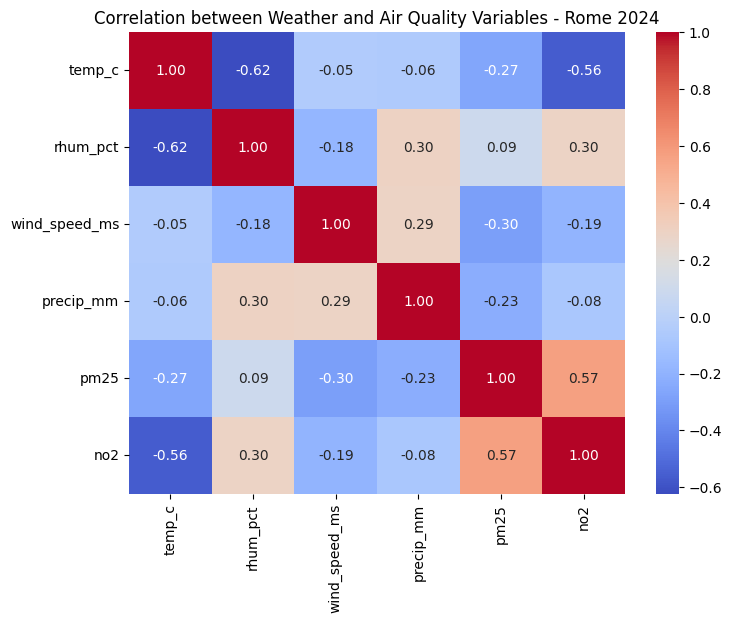

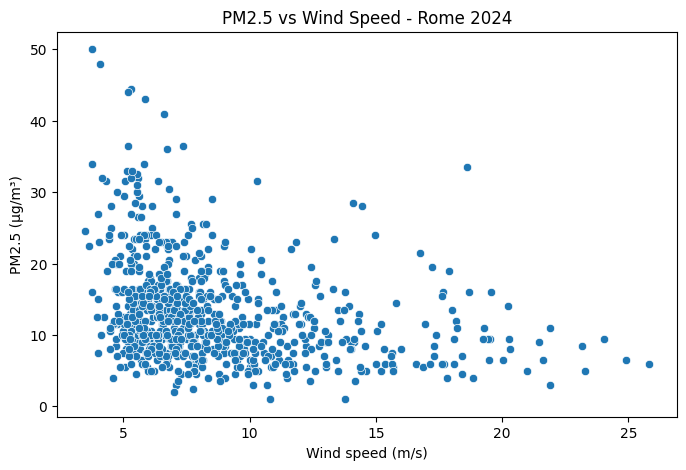

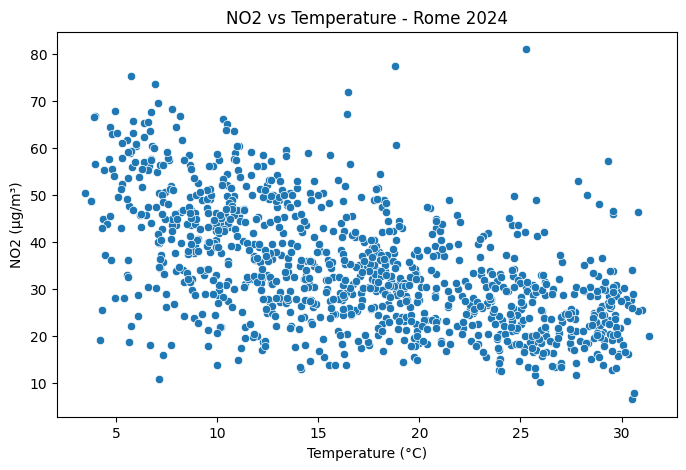

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Weather and Air Quality Variables - Rome 2024")
plt.show()

# === Step 4 – Targeted visualizations ===
plt.figure(figsize=(8,5))
sns.scatterplot(x="wind_speed_ms", y="pm25", data=merged)
plt.title("PM2.5 vs Wind Speed - Rome 2024")
plt.xlabel("Wind speed (m/s)")
plt.ylabel("PM2.5 (µg/m³)")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x="temp_c", y="no2", data=merged)
plt.title("NO2 vs Temperature - Rome 2024")
plt.xlabel("Temperature (°C)")
plt.ylabel("NO2 (µg/m³)")
plt.show()

### Findings:
- **Wind speed** shows a **negative correlation** with **PM2.5** and **NO₂**: windier days tend to disperse pollutants, lowering their concentrations.
- **Precipitation** is generally associated with **lower PM2.5 values** (washout effect: rain removes particulate matter from the atmosphere).
- **Temperature** and **relative humidity** show weaker or more variable relationships with pollutants; observed patterns are also influenced by seasonality (e.g., winter heating, traffic, stagnant conditions).

### Conclusion:
Weather conditions significantly influence air quality in Rome:
- **Wind** and **rain** contribute to lowering PM2.5 and NO₂ levels through dispersion and wet deposition.
- **Thermal** and **humidity** variables play a less direct role and may interact with seasonal and anthropogenic factors.


### **5.2:** Reflection
These findings are useful for **urban planning** and **public health**, for example, to anticipate pollution peaks during **stable, low-wind days** and to inform citizens about protective behaviors (e.g., limiting outdoor activities during critical episodes).